## Test Prompting

In [1]:
from argparse import Namespace

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM
from util import freeze_module

import torch
import torch.nn.functional as F

from langevin_dynamics import langevin_optimize, embedding_quantization
from prompt_tune import init_prompt, generate_from_prompt
from prompt_constraints import knowledge_sent_mle, dialog_response_mle
from constraints import embedding_fluency_constraint, simplex_fluency_constraint, emb_attr_control_constraint
from attribute_classifier.attribute_classifier_model import DoubleHeadModel

%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /home/schoiaj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/schoiaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# pretrained_model = 'gpt2-xl'
pretrained_model = 'google/flan-t5-xl'
# pretrained_model = 'facebook/opt-13b'
# pretrained_model = 'facebook/opt-6.7b'
# pretrained_model = 'facebook/opt-iml-max-1.3b'
# pretrained_model = 'EleutherAI/gpt-j-6B'
device = 'cuda:0'

tokenizer = AutoTokenizer.from_pretrained(pretrained_model)

if 't5' in pretrained_model or 't0' in pretrained_model:
    model = AutoModelForSeq2SeqLM.from_pretrained(pretrained_model)
    is_encoder_decoder = True
else:
    attribute_classifier_path = 'saved_models/gpt2-xl-sst2-pool_last-seed2022/best.pth'
    model = DoubleHeadModel.from_pretrained(pretrained_model,
                                            output_hidden_states=True,
                                            resid_pdrop=0,
                                            embd_pdrop=0,
                                            attn_pdrop=0,
                                            summary_first_dropout=0,
                                            num_labels=2)
    model.score.load_state_dict(torch.load(attribute_classifier_path))
    # model = AutoModelForCausalLM.from_pretrained(pretrained_model)
    is_encoder_decoder = False
model = model.to(device)
model.eval()
# Freeze model weights
freeze_module(model)

# open-ended generation
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id
model.config.bos_token_id = model.config.eos_token_id

## Zeroshot tests

In [5]:
prompt = "{}\n\nBased on the paragraph above can we conclude that \"{}\"?\n\nOPTIONS:\n- Yes\n- No\n - It’s impossible to say"

data = [
    [
            "A man inspects the uniform of a figure in some East Asian country.",
            "The man is sleeping"
        ],
        [
            "An older and younger man smiling.",
            "Two men are smiling and laughing at the cats playing on the floor."
        ],
        [
            "A black race car starts up in front of a crowd of people.",
            "A man is driving down a lonely road."
        ],
        ["A soccer game with multiple males playing.", "Some men are playing a sport."],
        [
            "A smiling costumed woman is holding an umbrella.",
            "A happy woman in a fairy costume holds an umbrella."
        ],
        [
            "Giada at Home is a television show hosted by Giada De Laurentiis. It first aired on October 18, 2008 on the Food Network. Food Network is an American basic cable and satellite televi- sion channel that is owned by Television Food Network, G.P., a joint venture and general partnership between Discovery, Inc. (which owns 70% of the network) and Tribune Media (which owns the remaining 30%).",
            "Giada at Home was available on TV.",
            ],
]
text = [prompt.format(a, b) for a,b in data]
inputs = tokenizer(text, return_tensors='pt', padding=True).to(device)
out = model.generate(**inputs, num_beams=1, max_new_tokens=10, early_stopping=True)
decoded = tokenizer.batch_decode(out)
for q, a in zip(text, decoded):
    print(a.replace(q, ''))
    print()

<pad> No</s></s></s></s></s></s>

<pad> It’s impossible to say</s>

<pad> No</s></s></s></s></s></s>

<pad> Yes</s></s></s></s></s></s>

<pad> It’s impossible to say</s>

<pad> Yes</s></s></s></s></s></s>



In [12]:
prompt = "{}\n\nWrite a sentence that can be logically inferred from the paragraph above, without repeating."

par = """After years of study, the Vatican’s doctrinal congregation has sent church leaders a confidential document concluding that "sex-change" procedures do not change a person’s gender in the eyes of the church."""
text = prompt.format(par)
print(text)
inputs = tokenizer(text, return_tensors='pt').to(device)
out = model.generate(**inputs, num_beams=10, max_new_tokens=20, early_stopping=True)
tokenizer.batch_decode(out)

After years of study, the Vatican’s doctrinal congregation has sent church leaders a confidential document concluding that "sex-change" procedures do not change a person’s gender in the eyes of the church.

Write a sentence that can be logically inferred from the paragraph above, without repeating.


['<pad> After years of study, the Vatican’s doctrinal congregation has sent church leaders ']

In [15]:
decoder_input_ids = torch.LongTensor([[tokenizer.eos_token_id]]).to(device)
model(**inputs, decoder_input_ids=decoder_input_ids).logits.shape

torch.Size([1, 1, 32128])

In [6]:
par = "A: so I watch the fish, you know. Whatever I can do to keep myself occupied. I like to have the TV on, because that usually keeps me, um, more occupied. It kind of takes the time away and I don’t realize, that’s really the only time I ever watch TV, is when I’m on the bike. and then usually after I’m done riding the bike, just to cool myself down, I usually take a walk, you know, and that just kind of uh, gets me, you know, to where I’m not quite as tired I guess. But it’s definitely a task. B: You think so? A: I can’t say that I really enjoy it."

prompt = "{}\n\nSummarize the dialogue above."

text = prompt.format(par)
inputs = tokenizer(text, return_tensors='pt').to(device)
out = model.generate(**inputs, num_beams=5, max_new_tokens=20, early_stopping=True)
tokenizer.batch_decode(out)

['<pad> A: I watch the fish, you know. Whatever I can do to keep myself occupied.']

## LD

In [ ]:
args = Namespace(num_iters=250,
                 max_length=20,
                 topk=5,
                 gamma=0,
                 min_stepsize=0.1,
                 stepsize=0.45,
                 quantize_embeds=True,
                 quantize_every=1,
                 stepsize_iters=1000,
                 stepsize_ratio=1,
                 grad_clip=0,
                 warmup_steps=40,
                 noise_iters=1,
                 noise_scheduler='geometric',
                 large_noise_iters="50,500,1000,1500",
                 large_gs_std="1,0.5,0.1,0.05",
                 gs_std=0.01)



input_ids = torch.randint(0, len(tokenizer) - 1, size=(1, 20)).to(device)
inputs_embeds = model.get_input_embeddings()(input_ids).detach()
# input_logits = torch.rand([1, 30, model.config.vocab_size]).to(device)

# contexts
# instruction = "In this task, you're given the beginning and the ending of a three-part story. Your job is to complete the short story by writing a middle sentence that seamlessly connects  the first and last sentence. Generated sentences must be short, have fewer than 10 words, and be simple as if narrating to a child. Avoid using any irrelevant extra information when creating the middle sentence, and use names (e.g. Jack, Barbara,...) instead of pronouns (e.g. he / she) wherever possible."

# example = "Beginning: Ray drive his car on a steep mountain road. Ending: Ray was fine but his car was totaled."
# left_context_ids = tokenizer(f"{instruction}\n{example}", return_tensors='pt').input_ids.to(device)

left_context_ids = tokenizer("The movie", return_tensors='pt').input_ids.to(device)

embed, history = langevin_optimize(model,
                                   inputs_embeds,
                                   args,
                                    {'embedding_fluency': [embedding_fluency_constraint, 
                                                 dict(left_context_ids=left_context_ids,
                                                      is_encoder_decoder=is_encoder_decoder,
                                                      target_ids=input_ids)],
                                    #  'attr_control': [emb_attr_control_constraint,
                                    #                   dict(left_context_ids=left_context_ids,
                                    #                   is_encoder_decoder=is_encoder_decoder,
                                    #                   attribute_class_idx=1)]  # positive
                                     },
                                   # {'simplex_fluency': [simplex_fluency_constraint, 
                                   #                dict(left_context_ids=left_context_ids,
                                   #                     is_encoder_decoder=is_encoder_decoder)],
                                   # },
                                   (0.5, 0.5),
                                   device=device)

Text(0.5, 1.0, 'lr')

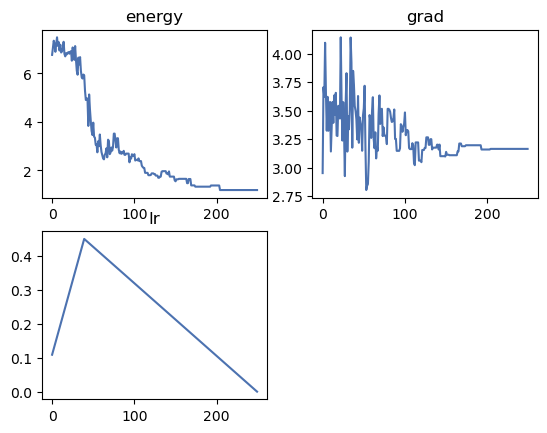

In [78]:
import matplotlib.pyplot as plt

plt.subplot(2, 2, 1)
plt.plot(history['energy'], label='energy')
plt.title('energy')
plt.subplot(2, 2, 2)
plt.plot(history['gradient'], label='grad')
plt.title('grad')
plt.subplot(2, 2, 3)
plt.plot(history['lr'], label='lr')
plt.title('lr')
# plt.legend()

In [79]:
quantized_ids, _ = embedding_quantization(model.get_input_embeddings(), embed)
# quantized_ids = embed.argmax(-1)

tokenizer.batch_decode(quantized_ids, skip_special_tokens=False)[0].replace('\xa0', ' ')

' was a huge commercial success, and was also a huge success in the media. People who were in'

In [70]:
tokenizer.batch_decode(model.generate(input_ids=left_context_ids, num_beams=5, max_new_tokens=100))[0].replace('\xa0', ' ')

'The potato is one of the most important crops in the world. It is also one of the most important crops in the United States.\n\nThe potato is one of the most important crops in the world. It is also one of the most important crops in the United States.\n\nThe potato is one of the most important crops in the world. It is also one of the most important crops in the United States.\n\nThe potato is one of the most important crops in the world. It is'

## Previous Exp

In [ ]:
# knowledge_sents = [
#     "Lionel Andrés Messi was born in 24 June 1987.",
#     "Lionel Andrés Messi is also known as Leo Messi.",
#     "Lionel Andrés Messi is an Argentine professional footballer who plays as a forward for Ligue 1 club Paris Saint-Germain and captains the Argentina national team.",
#     "Widely regarded as one of the greatest players of all time, Messi has won a record seven Ballon d'Or awards,[note 2] a record six European Golden Shoes, and in 2020 was named to the Ballon d'Or Dream Team.",
#     # "Until leaving the club in 2021, Lionel Messi had spent his entire professional career with Barcelona, where he won a club-record 35 trophies, including 10 La Liga titles, seven Copa del Rey titles and four UEFA Champions Leagues.",
#     "With his country, Messi won the 2021 Copa América and the 2022 FIFA World Cup.",
#     # "A prolific goalscorer and creative playmaker, Messi holds the records for most goals in La Liga (474), most hat-tricks in La Liga (36) and the UEFA Champions League (8), and most assists in La Liga (192) and the Copa América (17).",
#     "Messi has the most international goals by a South American male (98).",
#     # "Messi has scored over 790 senior career goals for club and country, and has the most goals by a player for a single club (672)."
# ]
# knowledge_ids = tokenizer(knowledge_sents,
#                           return_tensors='pt',
#                           padding=True).input_ids.to(device)

#                         #   padding='max_length',
#                         #   truncation=True,
#                         #   max_length=20
                        
# dialog_sents = ["Q: Who is your favorite soccer player? A: "] * len(knowledge_sents)
# dialog_ids = tokenizer(dialog_sents, return_tensors='pt', padding=True).input_ids.to(device)


# optimize
# prompt_ids, prompt_embed, bos_embed = init_prompt(model, tokenizer, num_prompts=20, prompt_len=20, device=device)

# reference = model.generate(dialog_ids, num_beams=4, do_sample=True, top_p=0.9, max_new_tokens=20, output_scores=True, return_dict_in_generate=True)
# ref_logits = reference.scores
# ref_ids = reference.sequences

# prompt_embed, energy_hist = langevin_optimize(model, 
#                                               prompt_embed, 
#                                               args, 
#                                               (knowledge_sent_mle, dialog_response_mle), 
#                                               (1, 0), 
#                                               ({'teacher_force': True, 
#                                                 'prompt_ids': prompt_ids,
#                                                 'knowledge_ids': knowledge_ids},
#                                                {'teacher_force': True, 
#                                                 'prompt_ids': prompt_ids,
#                                                 'context_ids': dialog_ids,
#                                                 'ref_ids': ref_ids}), 
#                                               device=device)

In [28]:
generated = generate_from_prompt(model, 
                                 prompt_embed,
                                 max_new_tokens=20,
                                 topk=5)[0]

# generated = model.generate(input_ids=prompt_ids, max_new_tokens=30, top_k=5)
print(tokenizer.batch_decode(generated, skip_special_tokens=False)[0])


Widely regarded as one of the greatest players of all time, Messi has won five La Liga titles
